In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img):
    img = (img+1)/2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [3]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)
batch_size = 32

cuda


In [4]:
# data loader

train_loader = torch.utils.data.DataLoader(
    dsets.MNIST(root="data/",
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor()
                ])),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dsets.MNIST(root="data/",
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor()
                ])),
    batch_size=batch_size,
    shuffle=True
)

In [5]:
# Network

def sample_z(batch_size=1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

d_noise = 100

G = nn.Sequential(
    nn.Linear(d_noise, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 28*28),
    nn.Tanh()
).to(device)

D = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 1),
    nn.Sigmoid()
).to(device)

In [6]:
# sample image

# z = sample_z()
# img_fake = G(z).view(-1, 28, 28)
# imshow(img_fake.squeeze().cpu().detach())

# z = sample_z(batch_size)
# img_fake = G(z)
# imshow_grid(img_fake)

# print(G(z).shape)
# print(D(G(z)).shape)

In [7]:
criterion = nn.BCELoss()

def evaluate_model(generator, discriminator):

    p_real, p_fake =0., 0.

    generator.eval()
    discriminator.eval()

    for img, label in test_loader:
        img, label = img.to(device), label.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.

    return p_real, p_fake

def init_params(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

In [8]:
init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)

p_real_trace = []
p_fake_trace = []

0
1
2
3
4
5
6
7
8
9
(epoch 10/10) p_real: 0.894620, p_g: 0.082194


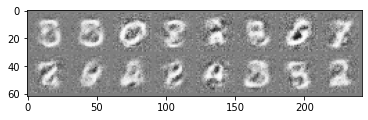

In [9]:
for epoch in range(10):
    print(epoch)
    G.train()
    D.train()

    for img, label in train_loader:
        img, label = img.to(device), label.to(device)

        optimizer_d.zero_grad()

        p_real = D(img.view(-1, 28 * 28))
        p_fake = D(G(sample_z(batch_size, d_noise)))

        # loss computation based on paper
        loss_real = -1 * torch.log(p_real)
        loss_fake = -1 * torch.log(1. - p_fake)
        loss_d = (loss_real + loss_fake).mean()

        # loss computation based on cross entropy
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + criterion(p_fake, torch.zeros_like(p_real).to(device))

        # update D parameters
        loss_d.backward()
        optimizer_d.step()

        # minimize V

        # init optimizer
        optimizer_g.zero_grad()

        p_fake = D(G(sample_z(batch_size, d_noise)))

        # loss computation based on paper
        loss_g = -1 * torch.log(p_fake).mean()

        # loss computation based on cross entropy
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device))

        loss_g.backward()

        # update G parameters
        optimizer_g.step()
    p_real, p_fake = evaluate_model(G, D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    if (epoch+1)%10 == 0:
        print('(epoch %i/10) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))